# XGBoost Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)
This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

## Why We Chose XGBoost for Bitcoin Fee Forecasting?

XGBoost is a gradient-boosted tree model that performs exceptionally well on structured tabular data. It can capture complex nonlinear relationships, handle missing values, and provide clear feature importance — all with minimal preprocessing effort.

- **Nonlinear pattern modeling:** Effectively captures temporal trends and interactions between mempool and market signals.

- **Robust to multicollinearity:** Handles correlated fee features (e.g., hourFee, halfHourFee) without degradation in performance.

- **Interpretability:** Outputs feature importance, helping us understand which signals drive predictions.

- **Practical baseline:** Provides strong performance with fast training and low overhead.

This notebook demonstrates the full training and evaluation pipeline of XGBoost.
> **Code Location**: See `scripts/baseline_xgboost.py` for the main model implementation and training pipeline.

In [1]:
import pandas as pd
import numpy as np
from sktime.forecasting.base import ForecastingHorizon
import joblib
import json
import matplotlib.pyplot as plt

import sys
sys.path.append("../scripts/xgboost")
from xgboost_utils import create_lag_features_fast
from xgboost_predict import predict_xgboost
sys.path.append("../src")
from plot_series import plot_series
from preprocess_raw_parquet import preprocess_raw_parquet
from custom_loss_eval import eval_metrics

## 1. Data Loading
To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [2]:
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df.dropna(inplace = True)
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Create lag features

We construct lag features for the target variable `recommended_fee_fastestFee` to help the XGBoost model learn from recent history.
Since our data is sampled every 15 minutes, we create 192 lag features to cover the past 48 hours.

In [3]:
lags = range(1, 193)  # 48 hours of 15-minute intervals
df_lag = create_lag_features_fast(df, 'recommended_fee_fastestFee', lags)
df_lag.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,recommended_fee_fastestFee_lag_183,recommended_fee_fastestFee_lag_184,recommended_fee_fastestFee_lag_185,recommended_fee_fastestFee_lag_186,recommended_fee_fastestFee_lag_187,recommended_fee_fastestFee_lag_188,recommended_fee_fastestFee_lag_189,recommended_fee_fastestFee_lag_190,recommended_fee_fastestFee_lag_191,recommended_fee_fastestFee_lag_192
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Why This Step Is Crucial
- **Encodes temporal dependencies** such as recent trends, reversals, and momentum in fee rate behavior.
- **Avoids data leakage** by only using past information to predict future values.
- **Supports tabular modeling** by converting time series into a flat structure usable by tree-based models like XGBoost.

## 3. Parameter Optimization

### Why We Use RandomizedSearchCV
We choose `RandomizedSearchCV` to optimize the model because it balances search breadth and computational efficiency. By sampling from defined ranges, it helps avoid overfitting while efficiently identifying robust configurations.

### Key Hyperparameters
`n_estimators`: [50, 100, 150] 
It controls the number of boosting rounds. Small values (50) may underfit, while higher values (150) may lead to better performance but risk overfitting. Keeping this modest helps reduce training time and keeps the search space focused.

`max_depth`: [1, 2, 3] 
It controls the maximum depth of individual trees. Shallow trees (1–3) are less likely to overfit and are more interpretable. Especially appropriate when the number of features is high and the time resolution is short (5-min data), helping avoid overly complex trees.

`learning_rate`: [0.01, 0.05, 0.1] 
Learning rate shrinks the contribution of each tree. Lower values slow down learning but improve generalization. Chosen to strike a balance between convergence speed and model stability.

`subsample`: [0.6, 0.8, 0.9] 
Fraction of rows used per tree. It introduces randomness ,helping prevent overfitting and improving robustness. 0.6–0.9 allows experimentation with more regularized models.

`colsample_bytree`: [0.6, 0.8, 0.9] 
Fraction of columns (features) used to build each tree. Especially helpful when there are many features. It helps prevent overfitting by decorrelating trees.

`gamma`: [1, 3, 5] 
Minimum loss reduction to make a split. It acts as a regularizer to control tree growth. Higher values force the model to make only meaningful splits.

`reg_lambda`: [5, 10, 20] 
L2 regularization on leaf weights. It prevents overly large weights, stabilizing the model especially with correlated features. It also helps handle multicollinearity and improve generalization.

`reg_alpha`: [5, 10, 20] 
L1 regularization (sparsity). It encourages feature selection by zeroing out less useful ones, and is particularly useful in high-dimensional datasets (e.g., many lag features).

In [4]:
param_dist = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [1, 2, 3],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__subsample': [0.6, 0.8, 0.9],
    'estimator__colsample_bytree': [0.6, 0.8, 0.9],
    'estimator__gamma': [1, 3, 5],
    'estimator__reg_lambda': [5, 10, 20],
    'estimator__reg_alpha': [5, 10, 20]
}


### Why This Step Is Crucial
- Helps identify the best-performing configuration without overfitting on a single setting.

- RandomizedSearch covers a wider parameter space than GridSearch, especially with limited resources.

- Prevents manual overfitting and confirms model robustness across plausible hyperparameter ranges.


## 4. (OPTIONAL) Model Generalization Experimentation

To assess how well XGBoost generalizes over time, we implement three weekly cross-validation strategies:

- **Expanding Window**: Trains from week 1 and expands one week at a time.  
- **Sliding Window**: Uses a fixed 1-week window that shifts forward.  
- **Reverse Expanding Window**: Starts from the second-to-last week and expands backward.  

All windowing logic is implemented in:  `scripts/experimentation/xgboost_window.py`
> **Note:** This script also includes instructions on how to run the experiments and generate results.

### 4.1 Expanding Window Forecasting - Weekly

We use expanding window cross-validation to evaluate XGBoost’s performance by adding the most recent weekly data (+7-day training, 1-day testing). This simulates a real-world setup where the model is retrained weekly using all past data and evaluated on the upcoming week.

**Key motivations:**

- Test HWES’s stability over longer time horizons  
- Identify periods of high error (e.g., spikes, market shifts)  
- Improve model readiness for production retraining  

Saved output: `results/tables/xgboost/...csv`

In [5]:
expanding_metrics = pd.read_csv("../results/tables/xgboost/expanding_window_weekly_predictions.csv")
expanding_metrics

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,1.6519,0.4355,0.5951,0.6213,0.2249,0.7243
1,2,2.1419,0.6634,0.7415,0.7370,0.2184,0.9719
2,3,3.9335,1.4710,1.2649,1.1977,0.3131,1.7996
3,4,2.7143,0.8505,0.8526,1.0112,0.6669,1.2055
4,5,2.5934,0.8381,0.8509,0.9043,0.4961,1.0631
5,6,2.6061,0.8859,0.8657,0.8544,0.2662,1.1205
6,7,7.8362,2.6992,2.4026,2.7345,0.2833,4.1982
7,8,2.4857,0.8119,0.8124,0.8614,0.1987,1.1125
8,9,2.0167,0.6648,0.6780,0.6738,0.2068,0.8843


### 4.2 Expanding Window Forecasting – Weekly – Reverse

We use reverse expanding window cross-validation to examine how the inclusion of different historical periods affects XGBoost’s ability to forecast the same target period.  
The model always predicts the **last 24 hours**, while the training window grows **backward** step by step in weekly increments. This setup simulates situations where older and older historical data is gradually added to training.

**Key motivations:**

- Evaluate XGBoost’s temporal sensitivity to historical context  
- Assess robustness to structural changes in past data  
- Understand how training on different time ranges impacts forecast stability  

Saved output: `results/tables/xgboost/....csv`

In [6]:
expanding_reverse_metrics = pd.read_csv("../results/tables/xgboost/expanding_window_reverse_weekly_predictions.csv")
expanding_reverse_metrics

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,2.1775,0.6873,0.7138,0.7765,0.2933,0.9679
1,2,2.1309,0.6539,0.7199,0.7571,0.2752,0.9764
2,3,2.3360,0.7646,0.7272,0.8443,0.3310,1.0306
3,4,2.3339,0.7850,0.7399,0.8090,0.3058,1.0178
4,5,2.2820,0.7542,0.7467,0.7810,0.2808,1.0289
5,6,2.2316,0.7463,0.7427,0.7425,0.2601,1.0190
6,7,2.2989,0.7819,0.7489,0.7681,0.2756,1.0290
7,8,2.3132,0.7921,0.7474,0.7738,0.2802,1.0300
8,9,2.3202,0.8011,0.7462,0.7729,0.2802,1.0325


### 4.3 Sliding Window Forecasting – Weekly

We apply a **sliding window** strategy using a fixed 7-day training window and a 1-day test window (96 × 15-minute intervals).  
This setup simulates a realistic retraining schedule where the model is updated regularly using only the most recent week of data.

**Key motivations:**

- Evaluate XGBoost’s short-term adaptability across time  
- Examine model behavior under a fixed training history  
- Identify periods of degraded performance (e.g., sudden fee spikes)  

Saved output:  
`results/tables/xgboost/....csv`

In [7]:
sliding_metrics = pd.read_csv("../results/tables/xgboost/sliding_window_weekly_predictions.csv")
sliding_metrics

,fold,custom_loss,std_diff,dev_error,mae,mape,rmse
0,1,1.6519,0.4355,0.5951,0.6213,0.2249,0.7243
1,2,2.4831,0.8555,0.8171,0.8105,0.2436,1.0645
2,3,4.0781,1.5077,1.2868,1.2836,0.3644,1.8098
3,4,2.4256,0.8259,0.7932,0.8065,0.4621,0.9949
4,5,2.1736,0.6161,0.7818,0.7757,0.3633,0.9449
5,6,2.8682,1.0128,0.9243,0.9311,0.2584,1.2907
6,7,13.5704,5.4081,4.2147,3.9476,0.3553,6.6432
7,8,2.3203,0.7190,0.7919,0.8094,0.1979,1.0002
8,9,1.9500,0.5845,0.6707,0.6948,0.2019,0.9105


## 5. Forecasting and Evaluation

We train the final XGBoost model on the full dataset, excluding the most recent 24 hours to match our evaluation strategy. This approach ensures that the model does not overfit to the latest data, especially when recent spikes might distort performance.

We load the optimized model from `results/models/xgboost.pkl` and apply it to the most recent 1-day holdout window (2025-05-10 to 2025-05-11). The final forecast is evaluated using previously defined metrics such as MAE, RMSE, and our custom composite loss.

In [8]:
df_new = df.iloc[:-96]
df_new_test = df_new.iloc[-96:]
df_new_test = df_new_test.reset_index()
model_path = "../results/models/xgboost.pkl"
df_forecast, metrics = predict_xgboost(df,df_new_test,model_path)

In [9]:
metrics

,value
custom_loss,2.5935
std_diff,0.9966
dev_error,0.7551
mae,0.8419
mape,0.4579
rmse,1.0487


#### Insights from Final XGBOOST Model Results:
...

### Why This Step Is Crucial
- This represents the finalized XGBoost model, trained with all historical data except the holdout period, mirroring a real-world deployment scenario.

- Excluding the last 24 hours prevents leakage and allows evaluation on unseen data.

- Ensures consistent comparison across all baseline models using the same holdout period.

- Loading the saved model enables reproducible inference and supports integration with other downstream components (e.g., dashboards or APIs).

## 6. Forcast Visualization

We plot the XGBoost model’s **1-day forecast** against actual observations over the final 24 hours.  
This provides a final visual check on how well the model tracks short-term fee dynamics.

<Figure size 1200x500 with 0 Axes>

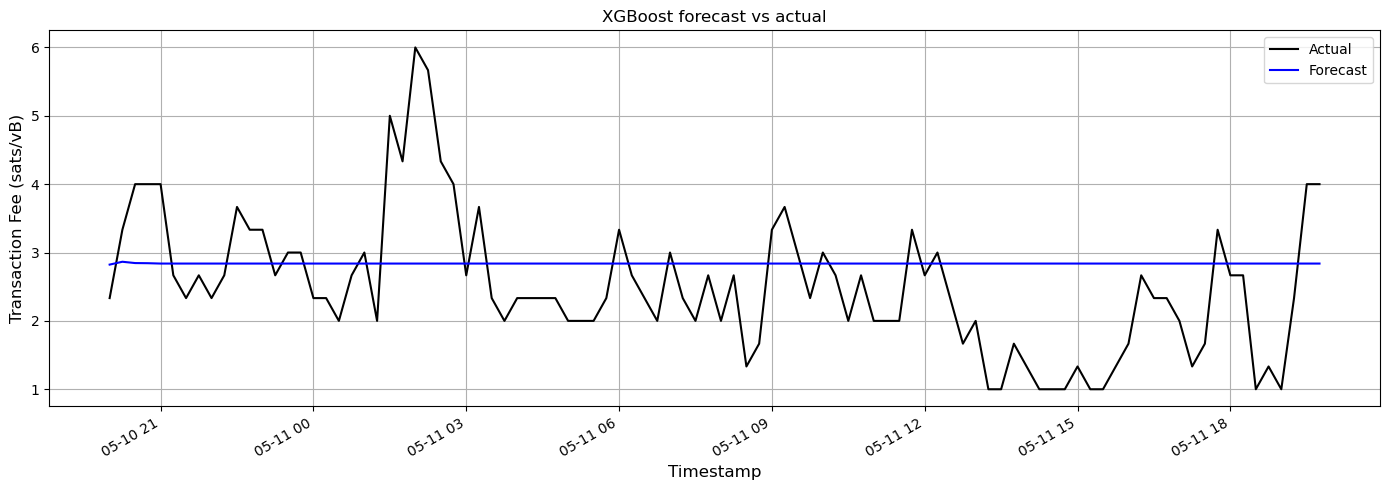

In [10]:
plt.figure(figsize=(12, 5))
plot_series(df_forecast, sid = "recommended_fee_fastestFee")
plt.title("XGBoost forecast vs actual")
plt.tight_layout()
plt.show()

## 7. Conclusion: XGBoost for Bitcoin Fee Forecasting
...

Based on the average metrics, expanding window performs better than sliding window across all metrics. Moreover, it slightly outperforms baseline (i.e. global median) within the 10-weeks data available. However, the performance is still far from ideal.